Rescaling the Stis g430l spectrum and measuring the strength of the Ca H & K lines.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from craftroom import resample

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

(-1e-16, 2e-16)

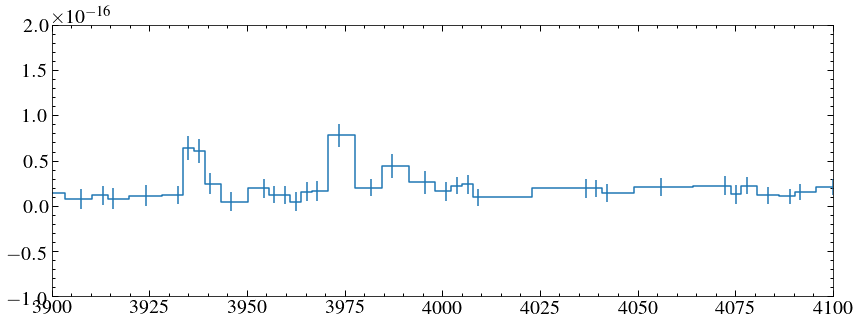

In [2]:
stis_opt = 'odlm41010_sx1.fits'
data = fits.getdata('../combined/'+stis_opt,1)[0]
wo = data['WAVELENGTH'][data['DQ']==0]
fo = data['FLUX'][data['DQ']==0]
eo = data['ERROR'][data['DQ']==0]
plt.errorbar(wo, fo, yerr=eo, drawstyle='steps-mid')
plt.xlim(3900, 4100)
plt.ylim(-1e-16, 0.2e-15)

In [3]:
mask = (fo>0) &  (wo <3355) | (wo > 3365) & (wo < 5321) | (wo > 5325) & (wo < 5476.5) | (wo > 5480.5) #cutting out overlap and cosmics
wo, fo, eo , dqo= wo[mask], fo[mask], eo[mask], data['DQ'][data['DQ']==0][mask]

In [4]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

In [5]:
g19data = glob.glob('../ir_data/PS_Gaia*')

gphot = np.genfromtxt(g19data[1], dtype=None, delimiter=',', names=True, encoding=None)
gpn, gpw, gpf, gpe = gphot['Band'], gphot['Wavelength'], gphot['Flux'], gphot['Error'] 
gpw*=10000
#plt.errorbar(gpw, gpf, yerr=gpe, marker='o', ls='none')

#plt.step(wo, fo, where ='mid')
#plt.xlim(wo[0], wo[-1])
#plt.ylim(0, np.max(fo)*1.1)

In [6]:
psbp = Table.read('/home/david/work/muscles/panstarrs_bandpasses.txt', format='ascii')
g_bp = Table.read('/home/david/work/filters/gaia/Bp.dat', format='ascii')
bpw, bpf = g_bp['col1'], g_bp['col2'] 
psw, psg = psbp['Wavelength']*10,psbp['gp1']

(-9e-17, 5.9e-16)

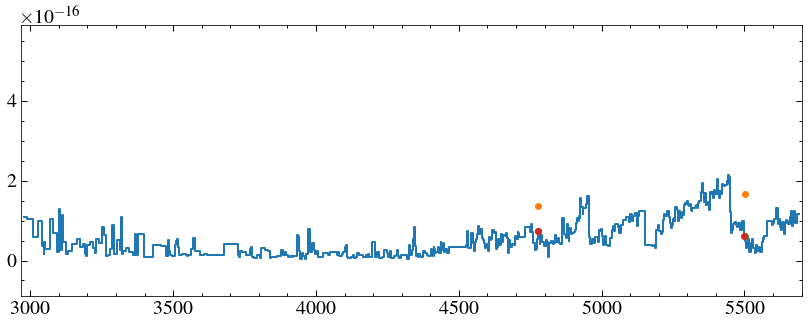

In [7]:
def make_phot(bp_w, bp_cc, w, f):
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    return np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)

def air_to_vac(wavelength):
    """
    Implements the air to vacuum wavelength conversion described in eqn 65 of
    Griesen 2006
    """
    wlum = wavelength.to(u.um).value
    return (1+1e-6*(287.6155+1.62887/wlum**2+0.01360/wlum**4)) * wavelength


go = make_phot(psw, psg, wo, fo)
bpo = make_phot(bpw, bpf, wo, fo)
phot_w = [4775.62,5500]
synphot = [go, bpo]

plt.step(wo, fo, where='mid', label='STIS G430L', lw=2)


phot_w_v = air_to_vac(phot_w*u.AA).value
gpw_v = air_to_vac(gpw*u.AA).value

plt.errorbar(gpw_v, gpf, yerr=gpe, marker='o', ls='none')
plt.errorbar(phot_w_v, synphot, marker='o', ls='none')
plt.errorbar(phot_w, synphot, marker='o', ls='none')
plt.xlim(wo[0]-10, wo[-1]+10)
plt.ylim(-0.9e-16, 5.9e-16)
#[plt.annotate(name.replace('_',''), (gpwi, 4e-16)) for name, gpwi in zip(gpn, gpw)]
#plt.yscale('log')
#plt.show()

In [8]:
print(synphot/np.array([gpf[5], gpf[3]]))
photscale = np.mean(synphot/np.array([gpf[5], gpf[3]]))
print(photscale)

[0.53174119 0.37242325]
0.4520822180518652


In [9]:
#add in the phoenix spectrum
phx = Table.read('../test_files/components/hlsp_muscles_model_phx_2mass-j23062928-0502285_na_v5_component-spec.ecsv')
pw, pf = phx['WAVELENGTH'], phx['FLUX']
pscale = phx.meta['NORMFAC']
pf *= pscale

pmask = (pw >= wo[0]) & (pw <= wo[-1])
pwi, pfi = pw[pmask], pf[pmask]
pwi, pfi = resample.bintogrid(pwi, pfi, newx = wo)

pwr, pfr = smear(pwi, pfi,250)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


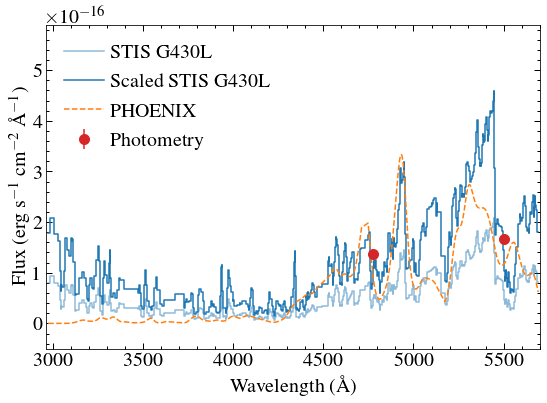

In [10]:
opw, opf, ope = gpw_v[gpw_v < wo[-1]], gpf[gpw_v < wo[-1]], gpe[gpw_v < wo[-1]]

plt.figure(figsize=(8,6))
plt.errorbar(opw, opf, yerr=ope, marker='o', ls='none', c = 'C3', markersize=10, zorder=10, label='Photometry')
#plt.errorbar(phot_w_v, synphot, marker='o', ls='none')
#plt.errorbar(phot_w, synphot, marker='o', ls='none')
plt.xlim(wo[0]-10, wo[-1]+10)
plt.ylim(-0.5e-16, 5.9e-16)
fob = convolve(fo,Box1DKernel(2))
eob = convolve(eo,Box1DKernel(2))/(2**0.5)
plt.step(wo, fob, where='mid', label='STIS G430L', c ='C0', alpha = 0.5)
fob, eob = fob/photscale, eob/photscale
plt.step(wo, fob, where='mid', label='Scaled STIS G430L', c='C0')
plt.plot(pwr, pfr, ls ='--', c='C1', label = 'PHOENIX')
plt.legend()
plt.xlabel('Wavelength (\AA)', size=20)
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)
plt.tight_layout()

383.5897861861104 99.88374151302888
780.5733164421813 241.28053484443637
3.8358978618611043e-16 9.988374151302889e-17
7.805733164421814e-16 2.412805348444364e-16


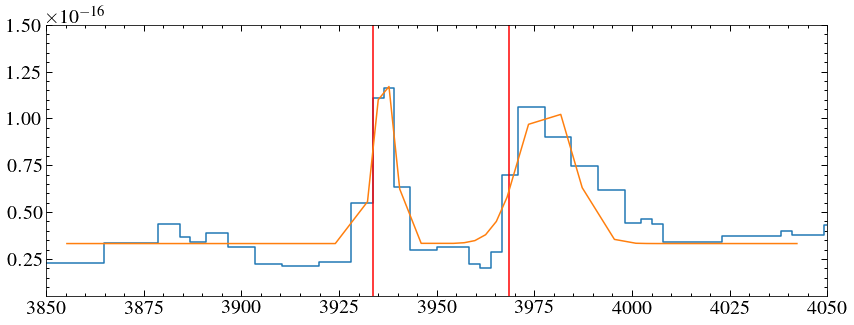

In [69]:
def gauss_flux(amp, std, off, ae, se, oe):
    """
    Calcualates the flux and error of a Gaussian with amplitude and stddev amp and std, with offset off
    """
    #off = 0.0
    off_err = 0
    if off != 0.0:
        amp += (-1*off)
        off_err = (oe/off)**2
        
    flux = ((2*np.pi)**0.5) * amp * std
    error = flux * (((ae/amp)**2)+((se/std)**2)+off_err)**0.5
    return flux, error
               

fitter = fitting.LevMarLSQFitter()

ca =[ 3933.6614, 3968.4673]
plt.step(wo,  fob, where='mid')
[plt.axvline(line, c='r') for line in ca]
plt.xlim(3850,4050)
plt.ylim(0.05e-16, 1.5e-16)

#for line in ca:
    #plt.axvline(line-40, c='r')
    #plt.axvline(line+40, c='g')
 #   mask = (wo > line-60) & (wo < line+60)
  #  gg_init = models.Const1D(0.0) + models.Gaussian1D(1e-16, line,1.0)
  #  gg_fit = fitter(gg_init, wo[mask], fob[mask], weights =1/eo[mask])
  #  plt.plot(wo[mask], gg_fit(wo[mask]))
mask = (wo > 3850) & (wo < 4050)
gg_init = models.Const1D(0.0)+models.Gaussian1D(1e-16, ca[0],10) + models.Gaussian1D(1e-16, ca[1],10)
gg_fit = fitter(gg_init, wo[mask], fob[mask], weights =1/eob[mask], maxiter=10000)
plt.plot(wo[mask], gg_fit(wo[mask]))
#plt.plot(pwr, pfr, ls ='--', c='C1', label = 'PHOENIX')
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
f1, e1 = gauss_flux(gg_fit[1].amplitude, gg_fit[1].stddev, gg_fit[0].amplitude, fit_e[1], fit_e[3], fit_e[0])
f2, e2 = gauss_flux(gg_fit[2].amplitude, gg_fit[2].stddev, gg_fit[0].amplitude, fit_e[4], fit_e[6], fit_e[0])
print(f1/1e-18, e1/1e-18)
print(f2/1e-18, e2/1e-18)
print(f1, e1)
print(f2, e2)
plt.savefig('hkzoom.png')

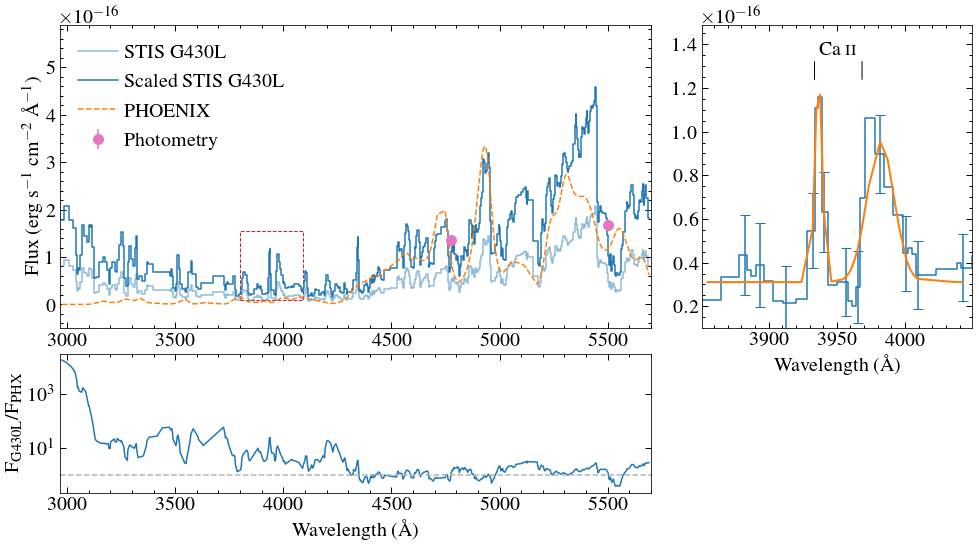

In [63]:
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

fig = plt.figure(figsize=(14, 8))
gs = GridSpec(6, 6, figure=fig)

ax = plt.subplot(gs[:4, :-2])
plt.errorbar(opw, opf, yerr=ope, marker='o', ls='none', c = 'C6', markersize=10, zorder=10, label='Photometry')
#plt.errorbar(phot_w_v, synphot, marker='o', ls='none')
#plt.errorbar(phot_w, synphot, marker='o', ls='none')
plt.xlim(wo[0]-10, wo[-1]+10)
plt.ylim(-0.5e-16, 5.9e-16)
fob = convolve(fo,Box1DKernel(2))
eob = convolve(eo,Box1DKernel(2))/(2**0.5)
plt.step(wo, fob, where='mid', label='STIS G430L', c ='C0', alpha = 0.5)
fob, eob = fob/photscale, eob/photscale
plt.step(wo, fob, where='mid', label='Scaled STIS G430L', c='C0')
plt.plot(pwr, pfr, ls ='--', c='C1', label = 'PHOENIX')
plt.legend()
#plt.xlabel('Wavelength (\AA)', size=20)
plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=20)
rect = patches.Rectangle((3801,0.1e-16),289,1.44e-16,linewidth=1,edgecolor='C3',facecolor='none', ls='--')
ax.add_patch(rect)
#plt.xticks(visible=False)

plt.subplot(gs[4:,:-2])
pwo, pfr = resample.bintogrid(pwr, pfr, newx=wo)
plt.plot(wo, fob/pfr)
plt.xlabel('Wavelength (\AA)', size=20)
plt.ylabel('F$_{\mathrm{G430L}}$/F$_{\mathrm{PHX}}$')
plt.xlim(wo[0]-10, wo[-1]+10)
plt.axhline(1.0, ls='--', c='0.7')
plt.yscale('log')

plt.subplot(gs[:4,-2:])
plt.step(wo,  fob, where='mid')
plt.errorbar(wo[::3], fob[::3], yerr=eob[::3], c='C0', ls='none', capsize=5, label = 'G430L')

#[plt.axvline(line, c='r') for line in ca]
[plt.annotate('',(line, 1.23e-16), xytext=(line, 1.33e-16), horizontalalignment='center', arrowprops=dict(arrowstyle='-')) for line in ca]
plt.annotate('Ca\,{\sc ii}',(np.mean(ca), 6e-17), xytext=(np.mean(ca), 1.35e-16), horizontalalignment='center')

plt.xlim(3851,4049)
plt.ylim(0.1e-16, 1.49e-16)
plt.plot(wo[mask], gg_fit(wo[mask]), lw=2, label='Model fit')
#plt.legend()
plt.xlabel('Wavelength (\AA)', size=20)
plt.tight_layout()
plt.subplots_adjust(hspace=0.45)
plt.savefig('../plots/t1_stis.png', dpi=150)
plt.savefig('../plots/t1_stis.pdf', dpi=150)

In [13]:
savdat = Table([wo, fo/photscale, eo/photscale, dqo], names = ['WAVELENGTH', 'FLUX', 'ERROR', 'DQ'])
ascii.write(savdat, 't1_g430m_edit.ecsv', format='ecsv', overwrite=True)

In [14]:
#f1, e1 = gauss_flux(gg_fit[1].amplitude, gg_fit[1].stddev, gg_fit[0].amplitude, fit_e[1], fit_e[3], fit_e[0])
#f2, e2 = gauss_flux(gg_fit[2].amplitude, gg_fit[2].stddev, gg_fit[0].amplitude, fit_e[4], fit_e[6], fit_e[0])

amps = [gg_fit[1].amplitude.value, gg_fit[2].amplitude.value]
means = [gg_fit[1].mean.value, gg_fit[2].mean.value]
stds = [gg_fit[1].stddev.value, gg_fit[2].stddev.value]
offs = [gg_fit[0].amplitude.value, gg_fit[0].amplitude.value]

lines_table = Table([amps, means, stds, offs], names =['Amplitude', 'Mean', 'Stddev', 'Offset'])
ascii.write(lines_table, '../paper/ca_emmision_lines_for.model.ecsv', format='ecsv', overwrite=True)     

Balmer lines.

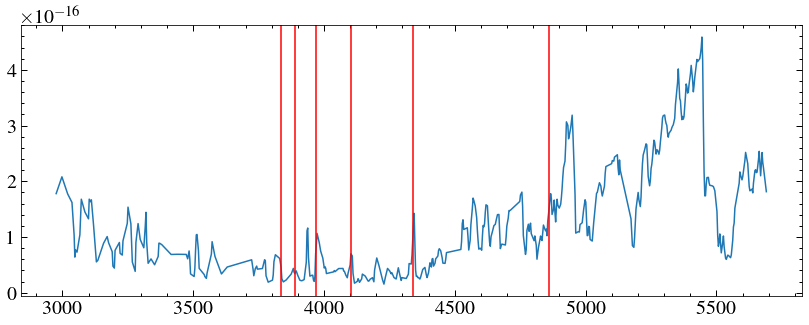

In [72]:
blines = np.array([656.45377,486.13615, 434.0462, 410.174, 397.0072, 388.9049, 383.5384])*10
names = ['alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta']
plt.plot(wo, fob)
[plt.axvline(line, c='r') for line in blines[1:]]
plt.show()



730.4808492608353 127.54590570649883
7.304808492608353e-16 1.2754590570649884e-16


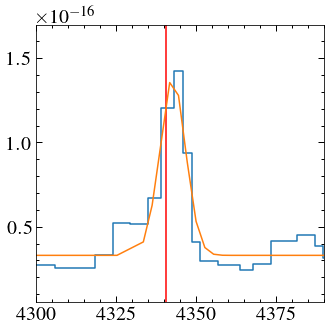

In [82]:
fitter = fitting.LevMarLSQFitter()

plt.figure(figsize=(5,5))
plt.step(wo,  fob, where='mid')
plt.xlim(4300, 4390)
plt.ylim(0.05e-16, 1.7e-16)
plt.axvline(blines[2], c='r')

mask = (wo > 4200) & (wo < 4400)
gg_init = models.Const1D(0.0)+models.Gaussian1D(1e-16, blines[2],10)
gg_fit = fitter(gg_init, wo[mask], fob[mask], weights =1/eob[mask], maxiter=10000)
plt.plot(wo[mask], gg_fit(wo[mask]))
#plt.plot(pwr, pfr, ls ='--', c='C1', label = 'PHOENIX')
fit_e = np.sqrt(np.diag(fitter.fit_info['param_cov']))
f1, e1 = gauss_flux(gg_fit[1].amplitude, gg_fit[1].stddev, gg_fit[0].amplitude, fit_e[1], fit_e[3], fit_e[0])
print(f1/1e-18, e1/1e-18)
print(f1, e1)
plt.tight_layout()
plt.savefig('hgamma.png')